### Affichage des classes

In [1]:
import os

# Chemin des datasets d'entraînement et de test
train_path = "PVF-10\\PVF_10_110x60\\train"
test_path = "PVF-10\\PVF_10_110x60\\test"

# Classes des datasets d'entraînement
classes = sorted(os.listdir(train_path))
print("Classes train :", *classes, sep="\n")

print("\nClasses test identiques ? => ", classes == sorted(os.listdir(test_path)))

Classes train :
01bottom dirt
02break
03Debris cover
04junction box heat
05hot cell
06shadow
07short circuit panel
08string short circuit
09substring open circuit
10healthy panel

Classes test identiques ? =>  True


### Affichage d'images

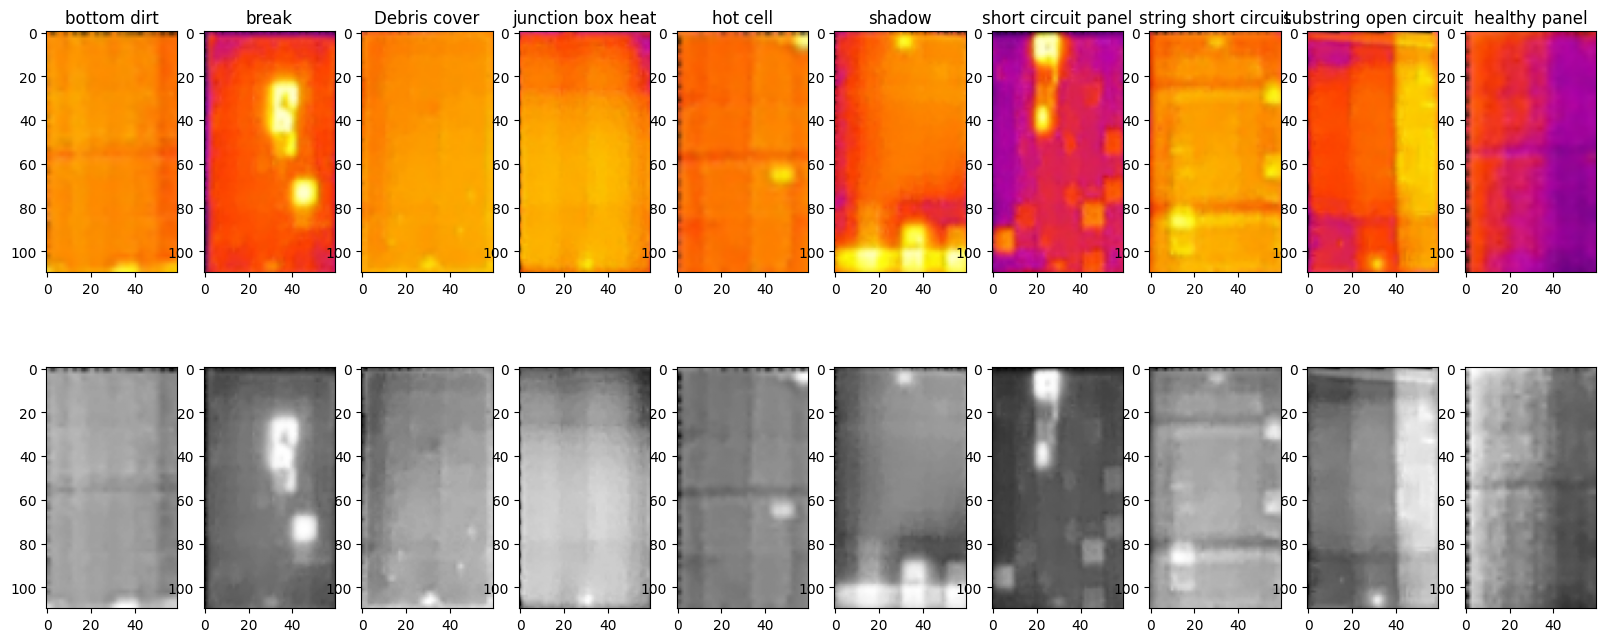

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Affichage d'une image par classe
nums_image = np.random.randint(50, size=len(classes))
fig, ax = plt.subplots(2, len(classes), figsize=(20, 8))
idx_ax= 0
for cls in classes:
    img_path = os.path.join(train_path, cls, os.listdir(os.path.join(train_path, cls))[nums_image[idx_ax]])
    img = cv2.imread(img_path)
    # Conversion BGR => RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[0,idx_ax].imshow(img_rgb)
    ax[0,idx_ax].set_title(cls[2:])
    # Conversion BGR => Niveau de gris
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ax[1,idx_ax].imshow(img_gray,cmap='gray')
    idx_ax+=1

plt.show()

### Chargement des datasets

In [ ]:
# Charger images et labels à partir d'un répertoire
def load_images_from_folder(folder):
    images = []
    labels = []
    
    # Pour chaque classe du répertoire
    for cls in classes: 
        class_path = os.path.join(folder, cls)
        
        # Pour chaque fichier dans la classe
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convertir en niveaux de gris
            image = cv2.resize(image, (60, 110)) # Redimensionner si besoin
            images.append(image)
            labels.append(cls)  # Associer l'image à sa classe
            
    return np.array(images), np.array(labels)

# Chargement images et labels d'entraînement et de test
images_train,labels_train = load_images_from_folder(train_path)
images_test,labels_test = load_images_from_folder(test_path)

### Extraction HOG  (Histogram of Oriented Gradient)

Taille d'un vecteur HOG : 2592


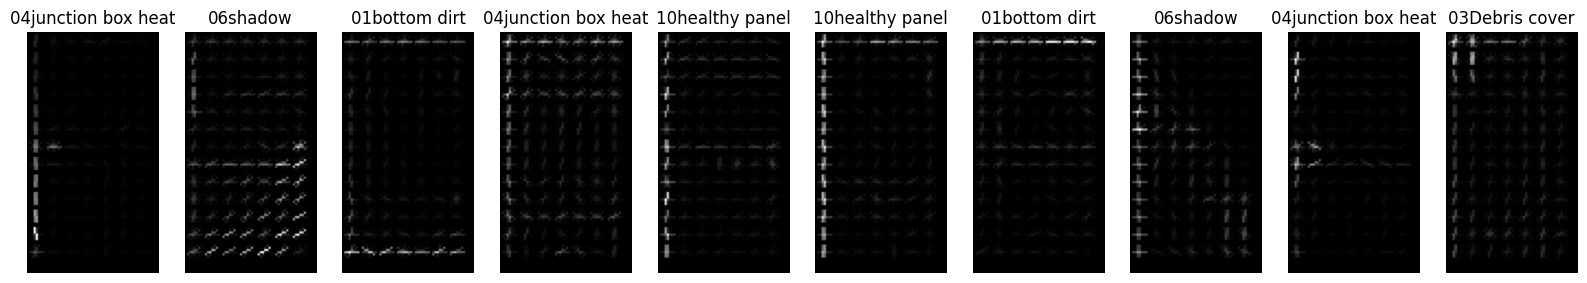

In [28]:
from skimage.feature import hog

# Extraction HOG  des images
def extract_hog_features(images):
    hog_features = []
    hog_images = []
    for image in images:
        hog_feature,hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(hog_feature)
        hog_images.append(hog_image)
    return np.array(hog_features),hog_images

# Extraction HOG des images d'entraînement et de test
X_train,hog_images_train = extract_hog_features(images_train)
X_test,hog_images_test = extract_hog_features(images_test)
y_train = labels_train
y_test = labels_test

print("Taille d'un vecteur HOG :", len(X_test[0]))

# Visualiser quelques images HOG de test
nums_image = np.random.randint(len(X_test), size=10)
hog_images_display = [hog_images_test[num] for num in nums_image]
labels_display = [y_test[num] for num in nums_image]
fig, axes = plt.subplots(1, 10, figsize=(20, 7))
for ax, hog_image, label in zip(axes.ravel(), hog_images_display, labels_display):
    ax.imshow(hog_image, cmap="gray")
    ax.set_title(label)
    ax.axis("off")
plt.show()

### Entraînement modèle SVM

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Grille de paramètres pour GridSearchCV
parametres = {
    'C':[0.1,1,10]
}

# Création du modèle avec cette grille de paramètres
svm = SVC(kernel="rbf", gamma="scale")
grid_model = GridSearchCV(svm, parametres)

# Entraînement du modèle
grid_model.fit(X_train, y_train)

# Meilleurs paramètres
print(grid_model.best_params_) 



{'C': 10}


### Evaluation SVM

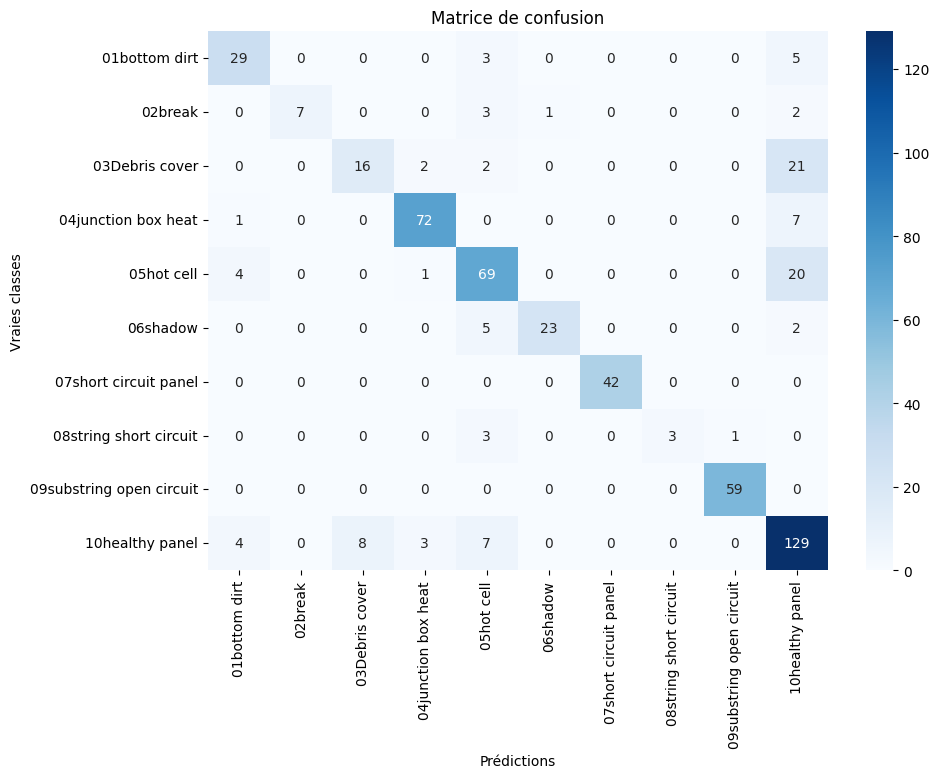

In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = grid_model.predict(X_test)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()

In [51]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
class_report = classification_report(y_test, y_pred, target_names=classes)

# Afficher le rapport
print("Rapport de classification :\n", class_report)

Rapport de classification :
                           precision    recall  f1-score   support

           01bottom dirt       0.76      0.78      0.77        37
                 02break       1.00      0.54      0.70        13
          03Debris cover       0.67      0.39      0.49        41
     04junction box heat       0.92      0.90      0.91        80
              05hot cell       0.75      0.73      0.74        94
                06shadow       0.96      0.77      0.85        30
   07short circuit panel       1.00      1.00      1.00        42
  08string short circuit       1.00      0.43      0.60         7
09substring open circuit       0.98      1.00      0.99        59
         10healthy panel       0.69      0.85      0.77       151

                accuracy                           0.81       554
               macro avg       0.87      0.74      0.78       554
            weighted avg       0.82      0.81      0.81       554



### Entraînement modèle KNN

In [46]:
# Grille de paramètres pour GridSearchCV
parametres = {
    'n_neighbors':np.arange(2,10)
}

# Création du modèle avec cette grille de paramètres
from sklearn import neighbors
knn =  neighbors.KNeighborsClassifier()
grid_model = GridSearchCV(knn, parametres)

# Entraînement du modèle
grid_model.fit(X_train, y_train)

# Meilleurs paramètres
print(grid_model.best_params_) 

{'n_neighbors': np.int64(8)}


### Evaluation KNN

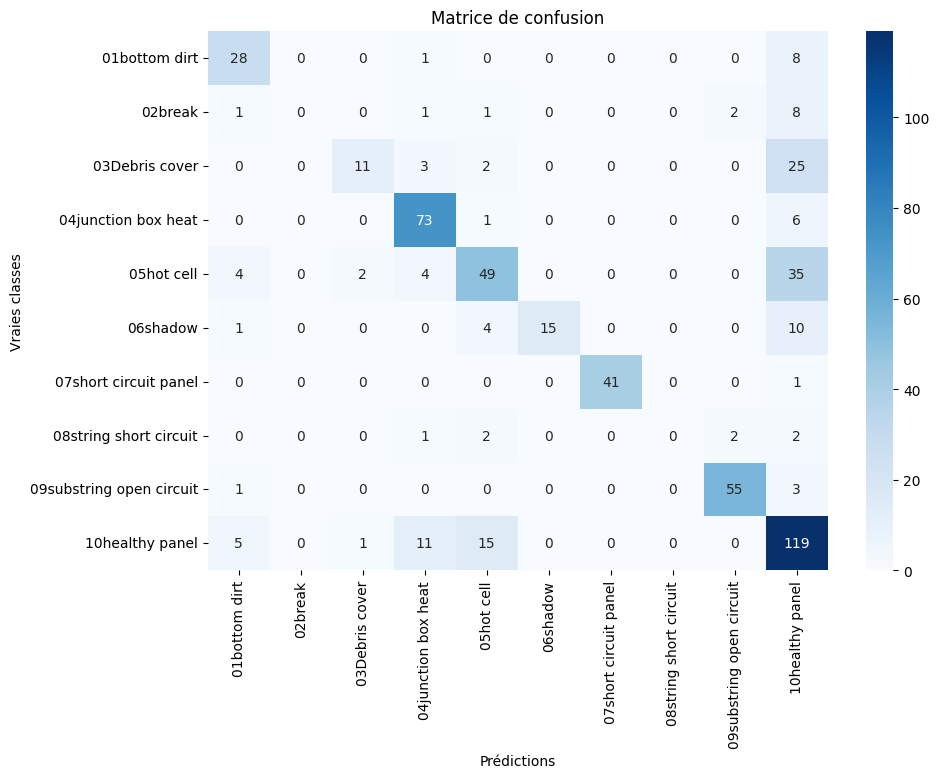

In [47]:
y_pred = grid_model.predict(X_test)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()

In [48]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
class_report = classification_report(y_test, y_pred, target_names=classes)

# Afficher le rapport
print("Rapport de classification :\n", class_report)

Rapport de classification :
                           precision    recall  f1-score   support

           01bottom dirt       0.70      0.76      0.73        37
                 02break       0.00      0.00      0.00        13
          03Debris cover       0.79      0.27      0.40        41
     04junction box heat       0.78      0.91      0.84        80
              05hot cell       0.66      0.52      0.58        94
                06shadow       1.00      0.50      0.67        30
   07short circuit panel       1.00      0.98      0.99        42
  08string short circuit       0.00      0.00      0.00         7
09substring open circuit       0.93      0.93      0.93        59
         10healthy panel       0.55      0.79      0.65       151

                accuracy                           0.71       554
               macro avg       0.64      0.57      0.58       554
            weighted avg       0.71      0.71      0.68       554



d:\Sources\PVF\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sources\PVF\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Sources\PVF\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
